In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

# 0. Functions

In [3]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [4]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'2.8% Median: {med1} \n Stats: {stat1} \n')
    print(f'5.6% Median: {med2} \n Stats: {stat2} \n')
    print(f'8.4% Median: {med3} \n Stats: {stat3} \n')
    print(f'11.2% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    return meds, maxs

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'AGR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [5]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Log Likelihood', fontsize=14, labelpad=15)
        ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [6]:
pklfile = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [8]:
XY.sample(20)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
20838,13653.55,0.961568,2.790,svea64-1,bwr,0.023370,4.0180,3.8730,0.160000,1.1250,3.7540,0.22000,0.027030,13.030,3.1620,1.815000,0.292100,0.011690,0.7485,0.37260
19319,4710.48,0.392519,3.120,atrium10x10-9,bwr,0.003840,1.4040,1.3340,0.022700,0.4142,1.3070,0.05144,0.003678,8.444,0.8498,0.217500,0.009981,0.011150,0.2337,0.11990
11944,54254.01,0.534367,2.030,ge8x8-1,bwr,0.325100,15.1100,12.2100,1.836000,3.9890,14.0700,1.24700,0.225100,13.320,5.1790,4.857000,6.805000,0.008762,2.9880,0.99030
13671,66910.17,0.407247,2.880,ge9x9-2,bwr,0.508800,18.4200,13.8900,2.428000,5.3650,17.0500,1.47900,0.282100,14.900,5.2360,5.473000,8.297000,0.009588,3.5660,1.07000
22153,36740.29,4612.466344,2.190,svea100-0,bwr,0.151300,10.4500,9.3790,0.014210,2.8160,7.3110,0.87070,0.054800,14.980,5.3040,2.768000,3.789000,0.015590,2.1400,0.81560
22656,45278.75,21.421788,4.010,svea100-0,bwr,0.247500,12.6700,10.8900,1.410000,3.9840,11.8700,1.12000,0.223900,18.170,5.2270,6.621000,5.328000,0.018300,2.6870,0.86320
324,43920.89,3315.830539,1.410,ce14x14,pwr,0.183300,12.4100,10.7700,0.069590,2.4680,9.5470,1.03800,0.088980,13.740,5.6110,3.211000,5.162000,0.017800,2.5950,0.91540
18536,54739.68,350.824551,5.080,atrium9x9-9,bwr,0.372000,15.1700,12.3800,1.395000,4.9920,13.8600,1.32300,0.261600,18.710,5.2400,6.735000,6.595000,0.019120,3.2210,0.92140
19673,24314.98,7.417340,3.670,atrium10x10-9,bwr,0.076450,6.9740,6.5570,0.510100,2.1940,6.5710,0.53980,0.091980,18.170,4.6600,4.909000,1.639000,0.018280,1.4280,0.58910
24337,2707.81,0.750642,0.711,candu28,phwr,0.001022,0.8286,0.7727,0.003095,0.2308,0.7589,0.02126,0.000713,2.569,0.1289,0.006967,0.000154,0.008331,0.1238,0.06364


## (a) Get test sample for LL calcs

In [10]:
# Choosing PHWR sample intentionally
sim_idx = 24337
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

In [ ]:
XY.drop(24337, inplace=True)

## (b) LL calcs for uncertainty = 3%, 9%, 15%, 21%

In [12]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [ ]:
uncs = [0.09, 0.15, 0.21] #need 0.03 for unc still
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [14]:
fullXY.head()

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,Likelihood0.03,LogLikelihood_0.03
1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,0.1187,...,0.000451,2.575,0.1198,0.006937,0.000123,0.008141,0.08695,0.04212,0.0,-1564.750454
2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,0.1209,...,0.000451,2.605,0.1198,0.006937,0.000123,0.009107,0.08695,0.04212,0.0,-1498.875029
3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,0.1224,...,0.000451,2.627,0.1198,0.006936,0.000123,0.009820,0.08695,0.04212,0.0,-1459.111695
4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,0.1238,...,0.000450,2.746,0.1198,0.006929,0.000123,0.013470,0.08695,0.04212,0.0,-1318.241646
5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,0.1238,...,0.000447,2.761,0.1198,0.006902,0.000123,0.013880,0.08695,0.04212,0.0,-1223.555908


# 2. LogLikelihood for 3 reactors with Uncertainty = 15%

In [44]:
l = 'Likelihood_0.15'
zname = [l, l, l, l]
rxtrs = ['PWR', 'AGR', 'PHWR', 'All']

In [16]:
fullXY_pwr = fullXY.loc[fullXY['ReactorType'] == 'pwr'].copy()
fullXY_agr = fullXY.loc[fullXY['ReactorType'] == 'agr'].copy()
fullXY_phwr = fullXY.loc[fullXY['ReactorType'] == 'phwr'].copy()
# be careful on ordering
meds, maxs = getstats_rxtr(fullXY_pwr, fullXY_agr, fullXY_phwr, fullXY, ll)
plotXY1 = fullXY_pwr.loc[fullXY_pwr[ll] > meds[0]]
plotXY2 = fullXY_agr.loc[fullXY_agr[ll] > meds[1]]
plotXY3 = fullXY_phwr.loc[fullXY_phwr[ll] > meds[2]]
plotXY4 = fullXY.loc[fullXY[ll] > meds[3]]

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


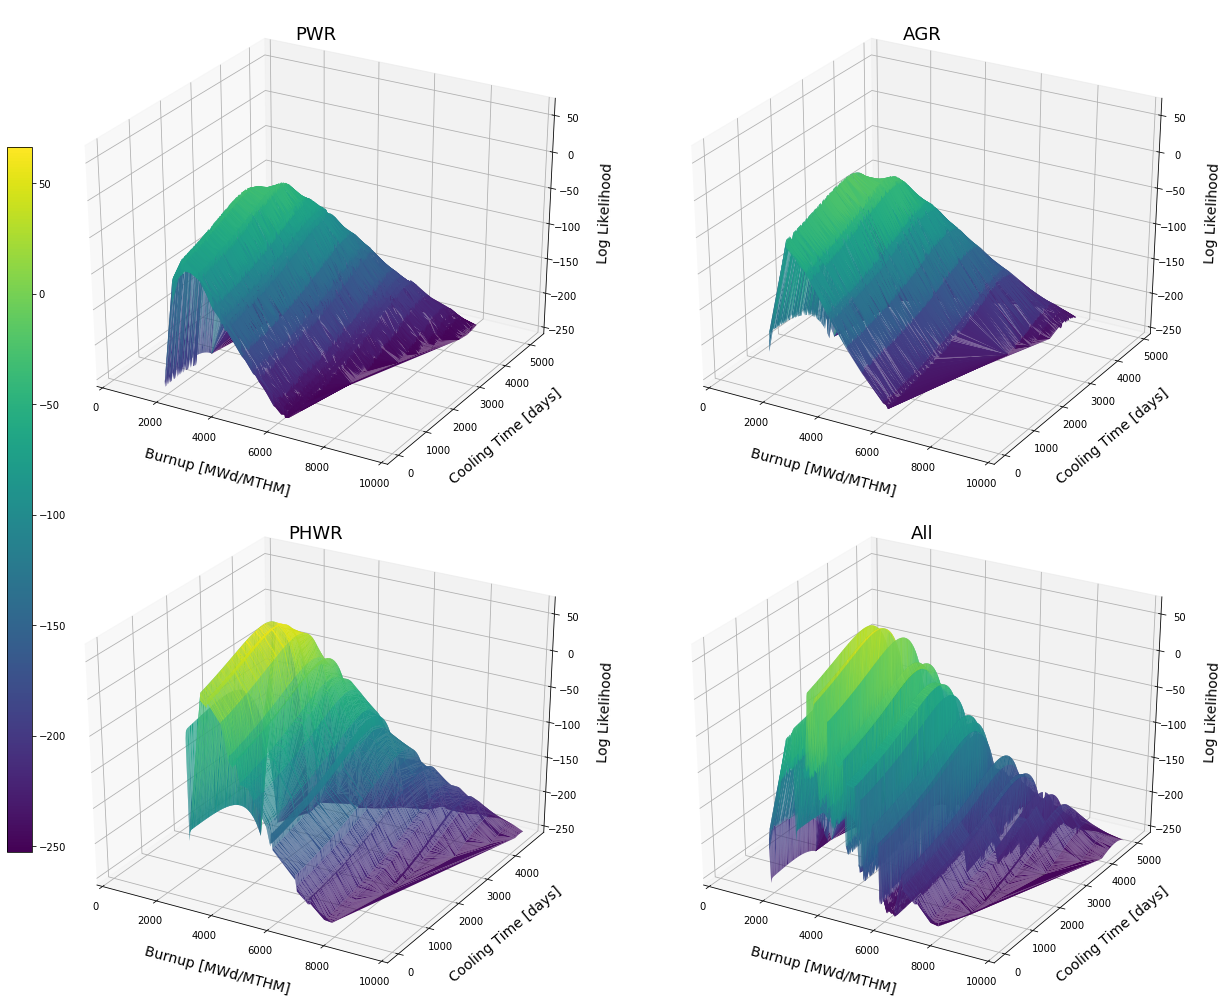

In [17]:
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, rxtrs, zname, vmin=min(meds), vmax=max(maxs))

# 3. LogLikelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [ ]:
ll1 = 'Likelihood_0.03'
ll2 = 'Likelihood_0.09'
ll3 = 'Likelihood_0.15'
ll4 = 'Likelihood_0.21'
zname = [l1, l2, l3, l4]
uncss = ['3% Unc', '9% Unc', '15% Unc', '21% Unc']

In [22]:
meds, maxs = getstats_unc(fullXY, ll1, ll2, ll3, ll4)

2.8% Median: -4654.185386669311 
 Stats: DescribeResult(nobs=73146, minmax=(-52306366591.27543, 87.24558183615221), mean=-248348075.00318956, variance=5.162133924256292e+18, skewness=-10.169449232832395, kurtosis=110.16796369125029) 

5.6% Median: -1124.0823739282782 
 Stats: DescribeResult(nobs=73146, minmax=(-13076591552.354626, 76.85047198887432), mean=-62086970.41849152, variance=3.226333649269764e+17, skewness=-10.169449259289005, kurtosis=110.16796431767646) 

8.4% Median: -474.304301367418 
 Stats: DescribeResult(nobs=73146, minmax=(-5811818401.155492, 70.76903867031615), mean=-27594177.42974485, variance=6.37300456352738e+16, skewness=-10.169449303383347, kurtosis=110.16796536171978) 

11.2% Median: -248.86582710883954 
 Stats: DescribeResult(nobs=73146, minmax=(-3269147800.4223323, 66.46270083428878), mean=-15521702.070222782, variance=2.016458397317569e+16, skewness=-10.169449365115364, kurtosis=110.16796682337954) 



In [56]:
cutoff = -4000

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


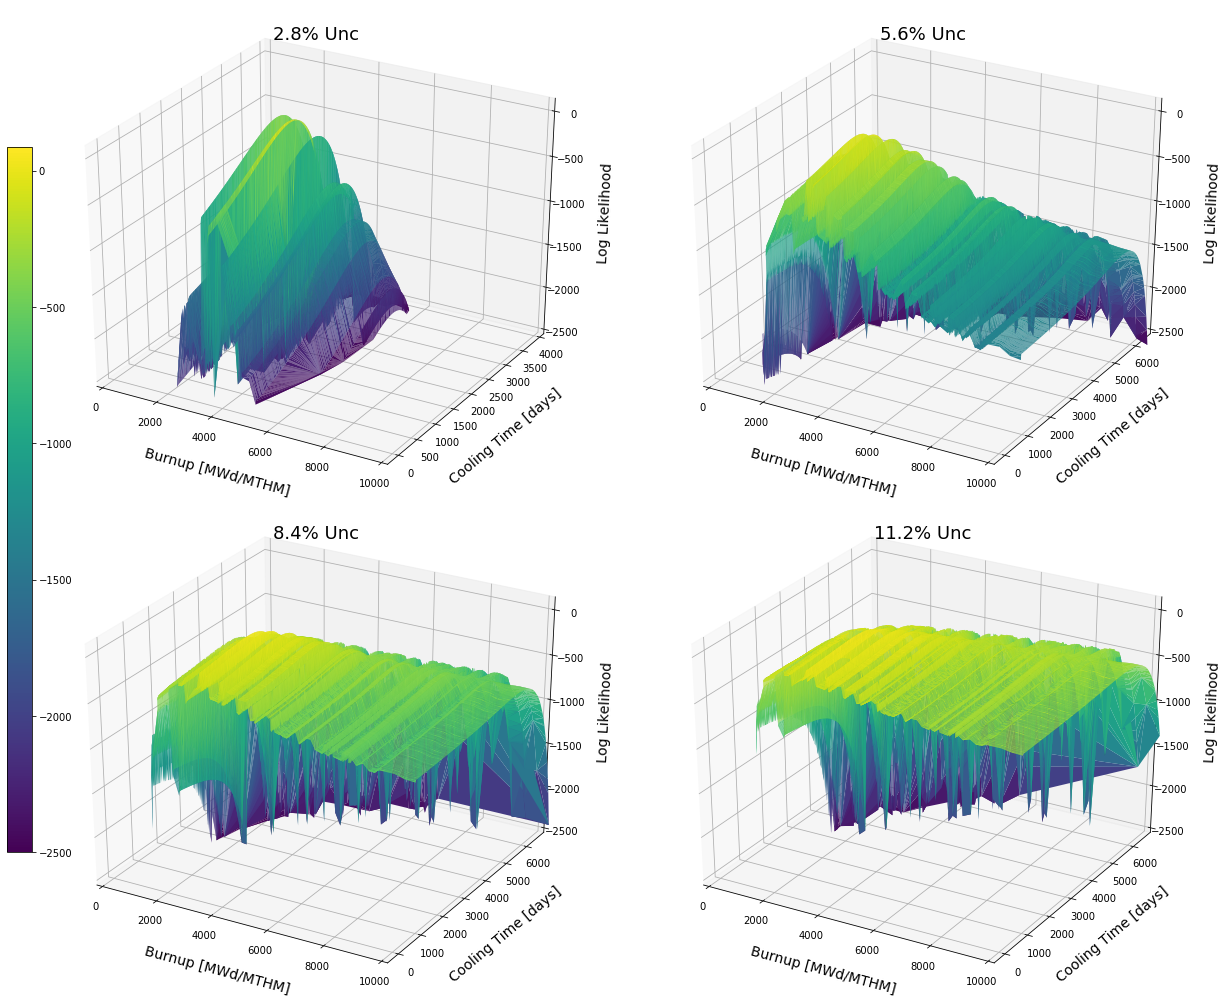

In [23]:
plotXY1 = fullXY.loc[fullXY[ll1] > cutoff]
plotXY2 = fullXY.loc[fullXY[ll2] > cutoff]
plotXY3 = fullXY.loc[fullXY[ll3] > cutoff]
plotXY4 = fullXY.loc[fullXY[ll4] > cutoff]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=cutoff, vmax=max(maxs))